In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import re
import numpy as np
from datetime import datetime
from utils import *

file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

date_string = "Nov 05 '22 01:00 AM UTC"
# Convert to datetime
iclr2023_reviewer_deadline = datetime.strptime(date_string, "%b %d '%y %I:%M %p %Z")

In [7]:
def extract_numeric_prefix(s):
    """
    Extracts the leading integer from a string.
    If no integer is found, returns NaN.
    """
    match = re.match(r'^(\d+)', str(s).strip())
    return int(match.group(1)) if match else np.nan

# b. List of reviewers
reviewers = ['reviewer1', 'reviewer2', 'reviewer3', 'reviewer4']

# c. Columns to extract numeric prefixes from
prefix_columns = [
    'recommendation',
    'confidence',
    'correctness',
    'technical_novelty_and_significance',
    'empirical_novelty_and_significance'
]

# d. Extract numerical prefixes for each reviewer and specified columns
for reviewer in reviewers:
    for col in prefix_columns:
        original_col = f'{reviewer}_{col}'
        new_col = f'{reviewer}_{col}_num'
        if original_col in df.columns:
            df[new_col] = df[original_col].apply(extract_numeric_prefix)
        else:
            # If the expected column is missing, create it with NaN
            df[new_col] = np.nan

# e. Convert Date Columns to Numerical Features
# General date columns
date_columns = ['cdate', 'tmdate']

# Reviewer-specific date columns
for reviewer in reviewers:
    date_columns.extend([f'{reviewer}_cdate', f'{reviewer}_tmdate'])

for col in date_columns:
    if col in df.columns:
        # Convert to datetime, coercing errors to NaT
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Option 1: Convert to timestamp (seconds since epoch)
        # Handle potential NaT by filling with 0 or another placeholder
        df[f'{col}_timestamp'] = df[col].astype(np.int64) / 1e9
        df[f'{col}_timestamp'] = df[f'{col}_timestamp'].replace([np.inf, -np.inf], np.nan)
        
        # Option 2: Extract date components
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_minute'] = df[col].dt.minute
        df[f'{col}_second'] = df[col].dt.second

# f. Ensure Direct Numerical Columns are in Numeric Format
# For example: 'reviewer1_length', 'reviewer2_length', etc.
for reviewer in reviewers:
    length_col = f'{reviewer}_length'
    if length_col in df.columns:
        df[length_col] = pd.to_numeric(df[length_col], errors='coerce')

# 4. Handle Missing Values

# a. Identify all numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# b. Fill NaNs with the median of each numerical column
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# 5. Compute the Target Variable

# a. Extract numerical recommendation scores
recommendation_cols = [f'{reviewer}_recommendation_num' for reviewer in reviewers]

# b. Ensure recommendation columns exist
recommendation_cols = [col for col in recommendation_cols if col in df.columns]

# c. Compute variance across reviewers for each row
df['recommendation_variance'] = df[recommendation_cols].var(axis=1)

# e. Create numerical decision scores
df['decision_num'] = df['decision'].apply(lambda x: 1 if 'Accept' in x else 0)

# 6. Prepare Features and Target

# a. Define target
target = 'decision_num'

# b. Define feature columns
# Exclude original string columns and columns related to decision
excluded_columns = [
    'title', 'keywords', 'TL;DR', 'abstract', 'decision_num', 'decision']

# Additionally exclude original string-based reviewer columns
string_based_cols = []
for reviewer in reviewers:
    string_based_cols.extend([
        f'{reviewer}_recommendation',
        f'{reviewer}_confidence',
        f'{reviewer}_summary_of_the_paper',
        f'{reviewer}_strength_and_weaknesses',
        f'{reviewer}_clarity_quality_novelty_and_reproducibility',
        f'{reviewer}_summary_of_the_review',
        f'{reviewer}_flag_for_ethics_review',
        f'{reviewer}_cdate',
        f'{reviewer}_tmdate',
        f'{reviewer}_recommendation_num'
    ])
excluded_columns.extend(string_based_cols)

# Remove any excluded columns from numerical_cols
feature_cols = [col for col in numerical_cols if col not in excluded_columns]

feature_cols = []

for col in numerical_cols:
    if col not in excluded_columns:
        feature_cols.append(col)
        

# c. Prepare the feature matrix X and target vector y
X = df[feature_cols]
y = df[target]

# 7. (Optional) Feature Scaling

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to a DataFrame for easier handling (optional)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

# 8. (Optional) Train-Test Split and Model Training

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Initialize the Linear Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== Logistic Regression Model Evaluation ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


=== Logistic Regression Model Evaluation ===
Mean Squared Error (MSE): 0.1132
Root Mean Squared Error (RMSE): 0.3364
R-squared (R²): 0.5441


/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_27329/281867770.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_timestamp'] = df[col].astype(np.int64) / 1e9
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_27329/281867770.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_year'] = df[col].dt.year
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_27329/281867770.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

## Permutation Importance

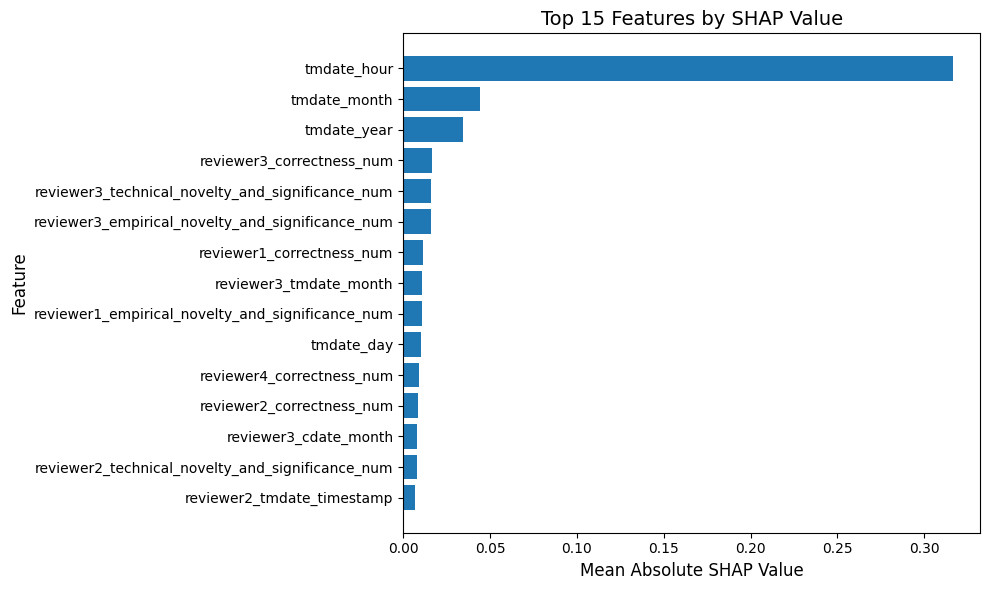

In [17]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)

# Extract feature importance
importances = perm_importance.importances_mean
sorted_indices = np.argsort(importances)[::-1][:15]

top_k_features = importances[sorted_indices]
feature_columns = np.array(feature_cols)[sorted_indices]

# Plot feature importance

plt.figure(figsize=(10, 6))
plt.barh(feature_columns[::-1], top_k_features[::-1], align='center')
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features by SHAP Value', fontsize=14)
plt.tight_layout()
plt.show()


## SHAP Value

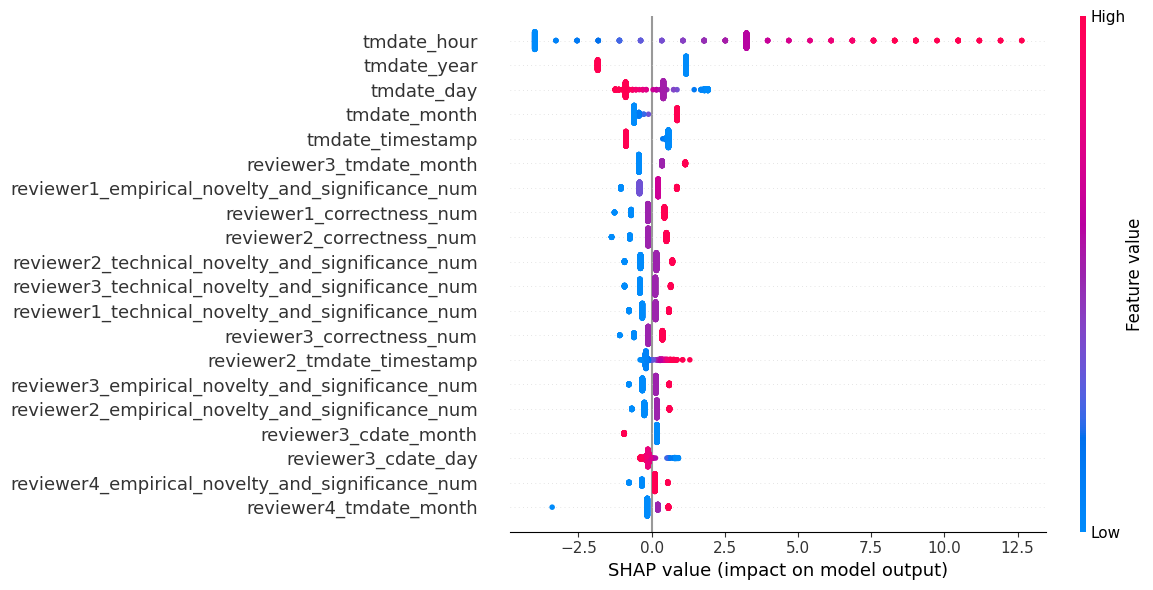

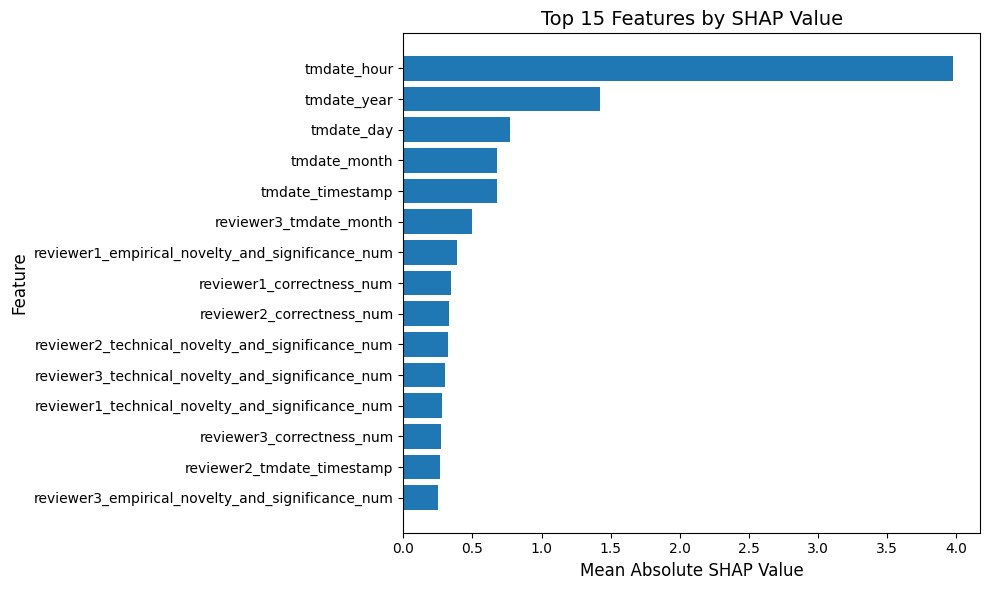

In [10]:
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a toy dataset
# SHAP explanation
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)

mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for easy sorting (optional)
import pandas as pd
shap_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': mean_abs_shap_values
})


# Increase plot size to avoid overlapping
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_size=(12, 6))
top_features = shap_df.sort_values(by='Importance', ascending=False).head(15)

# Optional: Adjust manually using matplotlib (if needed)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], align='center')
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features by SHAP Value', fontsize=14)
plt.tight_layout()
plt.show()
